In [1]:
import astropy as ast
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, EarthLocation, GeocentricTrueEcliptic, get_body, SkyCoord
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import plot_confusion_matrix
register_matplotlib_converters()

In [2]:
GENERATE_DATA = False # set GENERATE_DATA to True to generate data again. May take ~1h or more depending on processing power

In [3]:
data = pd.read_csv('solar_eclipse_data.csv')

# Select for years between 1900AD and 2100AD (to maintain accuracy of astropy data)
years_to_keep = data['Calendar Date'].str.split().apply(lambda x: x[0]).apply(lambda x: int(x) >= 1900 and int(x) <= 2050)
data = data[years_to_keep]

# Convert to ISO dates
data['Datetime'] = data['Calendar Date'] + ' ' + data['Eclipse Time']
data['Datetime'] = pd.to_datetime(data['Datetime'])
data['ISO Date'] = data['Datetime'].apply(lambda x: x.isoformat())
data['ISO Date'] = data['ISO Date'].apply(lambda x: Time(x))
data.head()

,Catalog Number,Calendar Date,Eclipse Time,Delta T (s),Lunation Number,Saros Number,Eclipse Type,Gamma,Eclipse Magnitude,Latitude,Longitude,Sun Altitude,Sun Azimuth,Path Width (km),Central Duration,Datetime,ISO Date
9280,9281,1900 May 28,14:53:56,-2,-1232,126,T,0.3943,1.0249,44.8N,46.5W,67,175,92,02m10s,1900-05-28 14:53:56,1900-05-28T14:53:56.000
9281,9282,1900 November 22,07:19:43,-2,-1226,131,A,-0.2245,0.9421,33.1S,64.8E,77,7,220,06m42s,1900-11-22 07:19:43,1900-11-22T07:19:43.000
9282,9283,1901 May 18,05:33:48,-1,-1220,136,T,-0.3626,1.0680,1.7S,98.4E,69,353,238,06m29s,1901-05-18 05:33:48,1901-05-18T05:33:48.000
9283,9284,1901 November 11,07:28:21,0,-1214,141,A,0.4758,0.9216,10.8N,68.9E,62,190,336,11m01s,1901-11-11 07:28:21,1901-11-11T07:28:21.000
9284,9285,1902 April 8,14:05:06,0,-1209,108,Pe,1.5024,0.0643,71.7N,142.4W,0,67,NaN,NaN,1902-04-08 14:05:06,1902-04-08T14:05:06.000


In [4]:
# All of the celestial bodies to generate synthetic data for
BODY_NAMES = ['moon', 'sun']

# Location is the Medicina Radio Observatory, located in Italy. Chosen for proximity to Greece
LOCATION = EarthLocation.of_site('medicina')

In [5]:
def get_coordinates(body):
    # Takes a Skycoord object, returns (theta, phi) in (deg, deg)
    angles = [float(i) for i in body.to_string().split(' ')]
    
    phi = angles[0]
    theta = angles[1]
    return phi, theta

def get_coordinate_rows(times):
    rows = defaultdict(list)
    for time in times:
        print(time)
        bodies = []

        with solar_system_ephemeris.set('builtin'):
            for body_name in BODY_NAMES:
                bodies.append(get_body(body_name, time, LOCATION))

        rows['time'].append(time)
        rows['location'].append(str(LOCATION))

        for body_name, body in zip(BODY_NAMES, bodies):
            theta, phi = get_coordinates(body)
            ecliptic = SkyCoord(theta, phi, frame='gcrs', unit=('deg', 'deg')).transform_to(GeocentricTrueEcliptic())
            coordinates = get_coordinates(ecliptic)
            coord_strings = ['theta', 'phi']

            for i in range(len(coord_strings)):
                c = coordinates[i]
                rows[body_name + '_' + coord_strings[i]].append(c)
    return rows

In [6]:
if GENERATE_DATA:
    times = data['ISO Date']
    rows = get_coordinate_rows(times)
    for k in rows.keys():
        data[k] = rows[k]

    data = data[['ISO Date', 'moon_theta', 'moon_phi', 'sun_theta', 'sun_phi']]
    data['eclipse'] = 1
    data.to_csv('solar_eclipse_pos_data.csv', index=False)
else:
    data = pd.read_csv('solar_eclipse_pos_data.csv')
data['ISO Date'] = data['ISO Date'].apply(lambda x: Time(x))

In [7]:
if GENERATE_DATA:
    # Generate the negative samples, i.e. times at which an eclipse is not occuring
    times = []
    for i in range(1, len(data)):
        # Difference in days
        days_difference = data['ISO Date'][i] - data['ISO Date'][i - 1]
        offset = 1
        # Enforce that datapoints in the non-eclipse class are sufficiently distant from datapoints in the eclipse class
        while offset < days_difference - 1:
            offset += abs(np.random.normal(5, 2))
            time = data['ISO Date'][i - 1] + offset
            times.append(time)

    rows = get_coordinate_rows(times)

    negative_data = pd.DataFrame(rows)
    negative_data['eclipse'] = 0
    negative_data.rename(columns={'time':'ISO Date'}, inplace=True)
    negative_data = negative_data.drop(columns='location')
    negative_data.to_csv('solar_eclipse_neg_data.csv', index=False)
else:
    negative_data = pd.read_csv('solar_eclipse_neg_data.csv')
negative_data['ISO Date'] = negative_data['ISO Date'].apply(lambda x: Time(x))

In [8]:
if GENERATE_DATA:
    data = pd.concat([data, negative_data], sort=True)
    data.to_csv('solar_eclipse_final_data.csv', index=False)
else:
    data = pd.read_csv('solar_eclipse_final_data.csv')
data = data.sort_values('ISO Date')
data['ISO Date'] = data['ISO Date'].apply(lambda x: Time(x))

In [9]:
# Plot to understand the data
def plot_parameter(param, n):
    positive = data[data['eclipse'] == 1]
    negative = data[data['eclipse'] == 0]
    
    fig, ax = plt.subplots()
    dates = [pd.to_datetime(d.value.split('T')[0]) for d in positive['ISO Date'][:n]]
    pos = plt.plot_date(dates, positive[param][:n], label='eclipse=1')
    dates = [pd.to_datetime(d.value.split('T')[0]) for d in negative['ISO Date'][:n]]
    neg = plt.plot_date(dates, negative[param][:n], label='eclipse=0')
    date_form = DateFormatter("%Y-%m-%d")
    ax.set_title('%s vs. date' % param)
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=120))
    plt.legend()
    plt.show()

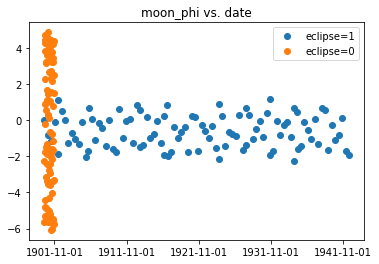

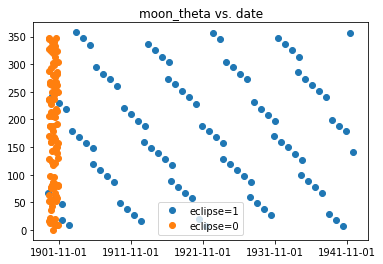

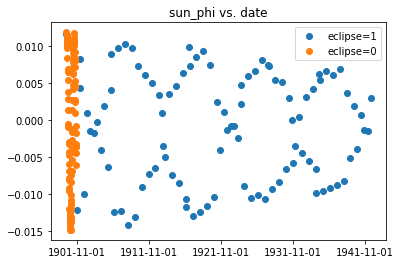

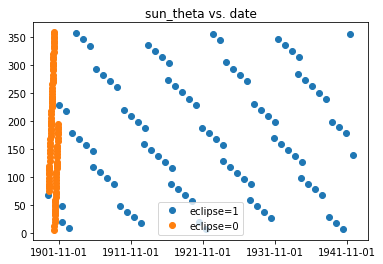

In [10]:
plot_parameter('moon_phi', 100)
plot_parameter('moon_theta', 100)
plot_parameter('sun_phi', 100)
plot_parameter('sun_theta', 100)

In [11]:
from sklearn.model_selection import train_test_split

X = np.array(data[['moon_theta', 'moon_phi', 'sun_theta', 'sun_phi']])
X = np.append(X, [[d.jd] for d in data['ISO Date']], axis=1)
y = np.array(data['eclipse'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, shuffle=False)
# X_train = X_train + np.random.normal(0, 0.1, size=X_train.shape) additive Gaussian noise

In [12]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [KNeighborsClassifier(3),
    SVC(kernel="sigmoid", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]


classifiers = dict(zip(names, classifiers))

Nearest Neighbors
Train score: 0.968859649122807
Test score: 0.9705140852789652
Linear SVM
Train score: 0.968859649122807
Test score: 0.9705140852789652
RBF SVM
Train score: 0.9986842105263158
Test score: 0.9705140852789652
Gaussian Process
Train score: 1.0
Test score: 0.9705140852789652
Decision Tree
Train score: 0.9706140350877193
Test score: 0.9697467938178231
Random Forest
Train score: 0.9701754385964912
Test score: 0.9705140852789652
Neural Net
Train score: 0.968859649122807
Test score: 0.9705140852789652
AdaBoost
Train score: 0.974561403508772
Test score: 0.9705140852789652
Naive Bayes
Train score: 0.968859649122807
Test score: 0.9705140852789652
QDA
Train score: 0.9982456140350877
Test score: 0.9945193467061274


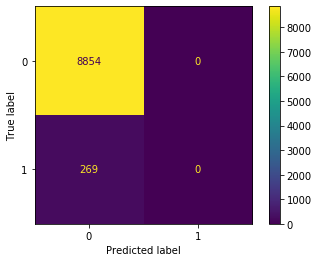

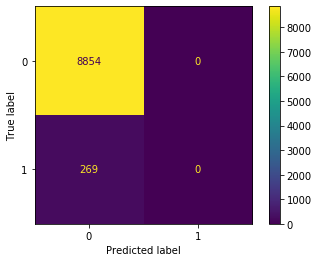

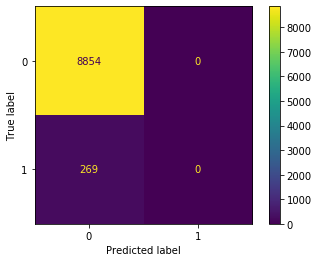

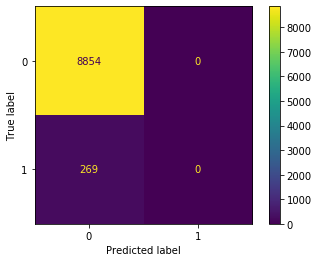

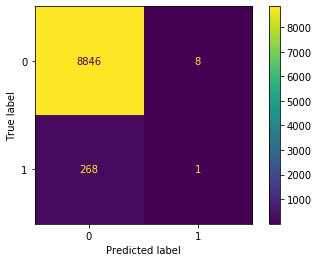

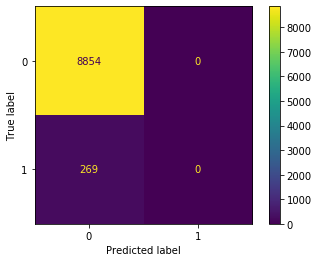

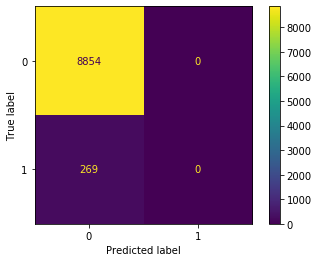

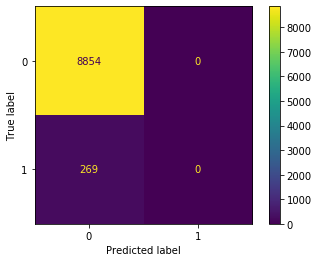

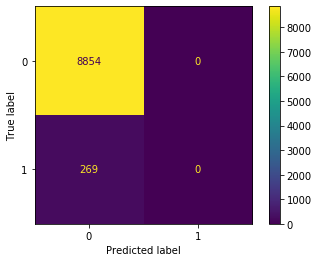

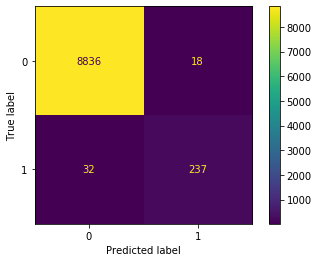

In [13]:
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    plot_confusion_matrix(clf, X_test, y_test)
    print(name)
    print('Train score:', clf.score(X_train, y_train))
    print('Test score:', clf.score(X_test, y_test))

QDA
Train score: 0.9986842105263158
Test score: 0.9952866381672696


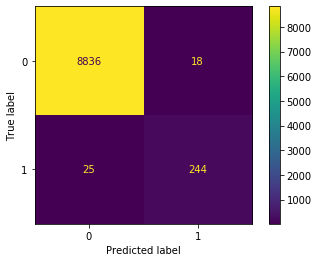

In [14]:
clf = QuadraticDiscriminantAnalysis(reg_param=0.01)
clf.fit(X_train, y_train)
plot_confusion_matrix(clf, X_test, y_test)
print('QDA')
print('Train score:', clf.score(X_train, y_train))
print('Test score:', clf.score(X_test, y_test))

In [15]:
from sklearn.model_selection import GridSearchCV

QDA
Train score: 0.9982456140350877
Test score: 0.9946289597720048


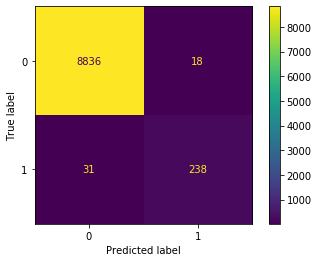

In [16]:
params = [{'reg_param': np.arange(0, 0.00001, 0.000001)}]
qda = QuadraticDiscriminantAnalysis()
clf = GridSearchCV(qda, params)
clf.fit(X_train, y_train)
plot_confusion_matrix(clf, X_test, y_test)
print('QDA')
print('Train score:', clf.score(X_train, y_train))
print('Test score:', clf.score(X_test, y_test))

In [17]:
clf.best_params_['reg_param']

3e-06

In [18]:
from sklearn.metrics import f1_score
f1_score(y_test, clf.predict(X_test))

0.9066666666666666